In [1]:
#from google.colab import drive
#drive.mount('/content/drive/')

## Case study: Metal ion concentration prediction

#### Prediction of the metal ion content from multi-parameter data
<b> Used K-Nearest Neighbor Regression with euclidean distance to predict total metal concentration (c_total), concentration of Cadmium (Cd) and concentration of Lead (Pb), using number of neighbors k = 1, 3, 5, 7.</b>

    - Nearest Neighbor Regression from https://scikit-learn.org/stable/modules/neighbors.html   
    - Implemented Leave-One-Out cross-validation and calculated the C-index for each output (c_total, Cd, Pb).
    - Implemented Leave-Replicas-Out cross-validation and calculated the C-index for each output (c_total, Cd, Pb).

## Import libraries

In [ ]:
# Libraries
import numpy as np
import pandas as pd
from scipy.stats import somersd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import LeaveOneOut
import matplotlib.pyplot as plt

## Read and visualize the dataset

<p> <b>Note:</b> This dataset differs slightly from the one used in the video lectures. <br>
<b>In this dataset, some mixtures have 3 replicas, while others have 4 replicas. </b> </p>

In the following cell (what i did):
- Read the file water_data.csv
- Print the dimesions of the dataset (i.e. number of rows and columns) and display the first 20 rows.
- Identify the inputs and the outputs columns.
- Identify the number of mixtures with 3 replicas and 4 replicas.

In [3]:
df=pd.read_csv("/content/water_data.xlsx")

In [4]:
df.shape

(243, 6)

In [5]:
df.head(20)

,Mod1,Mod2,Mod3,c_total,Cd,Pb
0,-0.994673,-0.662192,0.327797,14.0,2.8,11.2
1,-0.982196,-0.662465,0.976950,14.0,0.0,14.0
2,2.063228,2.552820,1.681019,200.0,200.0,0.0
3,-0.839376,-0.586206,-1.471322,5000.0,3000.0,2000.0
4,-0.846858,-0.543135,-1.404644,5000.0,4000.0,1000.0
5,1.158529,0.706564,0.458484,500.0,500.0,0.0
6,-0.276121,-0.453909,-1.142868,2000.0,1600.0,400.0
7,2.006048,2.329848,1.309893,200.0,160.0,40.0
8,-0.715458,-0.648863,-0.258570,14.0,14.0,0.0
9,-0.682725,-0.563265,-0.500104,100.0,0.0,100.0


The output columns are Cd, Pb, c_total. And the input columns are Mod1, Mod2, Mod3.

In [6]:
X = df[['Mod1', 'Mod2', 'Mod3']]
y = df[['c_total', 'Cd', 'Pb']]

In [7]:
replica_counts = (
    df
    .groupby(['c_total', 'Cd', 'Pb'])
    .size()
    .reset_index(name='replica_count')
)
replica_summary = replica_counts['replica_count'].value_counts().sort_index()
print("Replica Summary based on c_total, Cd, Pb:")
print(replica_summary)

Replica Summary based on c_total, Cd, Pb:
replica_count
3    25
4    42
Name: count, dtype: int64


In [8]:
df['row_id'] = df.index

In [9]:
replica_locations = (
    df
    .groupby(['c_total', 'Cd', 'Pb'])
    .agg(
        replica_count=('row_id', 'size'),
        rows=('row_id', list)
    )
    .reset_index()
)

In [10]:
replicas_3 = replica_locations[replica_locations['replica_count'] == 3]
replicas_4 = replica_locations[replica_locations['replica_count'] == 4]

print(f"Number of mixtures with 3 replicas: {len(replicas_3)}")
print(f"Number of mixtures with 4 replicas: {len(replicas_4)}")

Number of mixtures with 3 replicas: 25
Number of mixtures with 4 replicas: 42


In [20]:
replica = int(input('Enter which replica you want to see. 4 or 3? '))

Enter which replica you want to see. 4 or 3? 3


In [22]:
if replica == 3:
    print(f"Example of a mixture with 3 replicas at position {replicas_3.iloc[0]['rows']}:")
    display(df.loc[replicas_3.iloc[0]['rows']])
elif replica == 4:
    print(f"Example of a mixture with 4 replicas at position {replicas_4.iloc[0]['rows']}:")
    display(df.loc[replicas_4.iloc[0]['rows']])
else:
    print("Please enter either 3 or 4.")

Example of a mixture with 3 replicas at position [109, 110, 220]:


,Mod1,Mod2,Mod3,c_total,Cd,Pb,row_id
109,-0.980047,-0.663190,-0.342273,0.0,0.0,0.0,109
110,-0.971147,-0.663371,-0.171038,0.0,0.0,0.0,110
220,-0.983741,-0.663190,0.272495,0.0,0.0,0.0,220


## C-index code

In [ ]:
# This fuction is used as the evaluation metric in the Leave-One-Out (LOOCV) and Leave-Replicas-Out (LROCV) cross-validation methods.

def cindex(true, pred):
    s_d = somersd(true, y=pred, alternative='two-sided')
    c_index = (s_d.statistic + 1.0)/2.0
    return c_index

## KNN_CrossValidator Class

In [14]:
class KNN_CrossValidator:
    def __init__(self, X, y, cindex_func, k_values):
        self.X = X
        self.y = y
        self.cindex_func = cindex_func
        self.k_values = k_values
        self.loocv_results = {}
        self.lrocv_results = {}

    def _calculate_all_metrics(self, y_true_dict, y_pred_dict):
        metrics_results = {}
        for target_name in self.y.columns:
            y_true = y_true_dict[target_name]
            y_pred = y_pred_dict[target_name]

            c_index = self.cindex_func(y_true, y_pred)

            metrics_results[target_name] = {'c_index': c_index}
        return metrics_results

    def perform_loocv(self):
        print("\nPerforming Leave-One-Out Cross-Validation...")
        for k in self.k_values:
            print(f"Running LOOCV for k = {k}")
            knn = KNeighborsRegressor(n_neighbors=k)
            loo = LeaveOneOut()

            y_true_dict = {target_name: [] for target_name in self.y.columns} # prepare dictionary for true values of Pb,Cd, c_total
            y_pred_dict = {target_name: [] for target_name in self.y.columns} # prepare dictionary for prdeicted values of Pb,Cd, c_total

            for train_index, test_index in loo.split(self.X):
                X_train, X_test = self.X.iloc[train_index], self.X.iloc[test_index]
                y_train, y_test = self.y.iloc[train_index], self.y.iloc[test_index]

                knn.fit(X_train, y_train)
                y_pred_fold = knn.predict(X_test)

                for i, target_name in enumerate(self.y.columns):
                    y_true_dict[target_name].append(y_test[target_name].values[0])
                    y_pred_dict[target_name].append(y_pred_fold[0, i])

            self.loocv_results[k] = self._calculate_all_metrics(y_true_dict, y_pred_dict)
        print("LOOCV complete.")

    def perform_lrocv(self, replica_locations):
        print("\nPerforming Leave-Replicas-Out Cross-Validation...")
        all_mixture_rows = replica_locations['rows'].tolist()

        for k in self.k_values:
            print(f"Running LROCV for k = {k}")
            knn = KNeighborsRegressor(n_neighbors=k)

            y_true_dict = {target_name: [] for target_name in self.y.columns}
            y_pred_dict = {target_name: [] for target_name in self.y.columns}

            for mixture_rows in all_mixture_rows:
                test_index = np.array(mixture_rows)
                train_index = np.array([i for i in self.X.index if i not in test_index])

                if len(train_index) == 0:
                    continue

                X_train, X_test = self.X.iloc[train_index], self.X.iloc[test_index]
                y_train, y_test = self.y.iloc[train_index], self.y.iloc[test_index]

                knn.fit(X_train, y_train)
                y_pred_fold = knn.predict(X_test)

                for i, target_name in enumerate(self.y.columns):
                    y_true_dict[target_name].extend(y_test[target_name].values)
                    y_pred_dict[target_name].extend(y_pred_fold[:, i])

            self.lrocv_results[k] = self._calculate_all_metrics(y_true_dict, y_pred_dict)
        print("LROCV complete.")

    def _print_results(self, cv_type, results):
        print(f"\n{cv_type} C-index Results:\n")
        for k, k_results in results.items():
            print(f"k = {k}:\n")
            for target, metrics in k_results.items():
                print(f"{target}:")
                print(f"C-index: {metrics['c_index']:.4f}\n")

## Leave-One-Out cross-validation

In [15]:
k_values = range(1, 8, 2)

knn_validator = KNN_CrossValidator(X, y, cindex, k_values)

knn_validator.perform_loocv()

knn_validator._print_results("LOOCV", knn_validator.loocv_results)


Performing Leave-One-Out Cross-Validation...
Running LOOCV for k = 1
Running LOOCV for k = 3
Running LOOCV for k = 5
Running LOOCV for k = 7
LOOCV complete.

LOOCV C-index Results:

k = 1:

c_total:
C-index: 0.9122

Cd:
C-index: 0.9194

Pb:
C-index: 0.8836

k = 3:

c_total:
C-index: 0.9108

Cd:
C-index: 0.9030

Pb:
C-index: 0.8772

k = 5:

c_total:
C-index: 0.8912

Cd:
C-index: 0.8558

Pb:
C-index: 0.8508

k = 7:

c_total:
C-index: 0.8786

Cd:
C-index: 0.8242

Pb:
C-index: 0.8298



## Leave-Replicas-Out cross-validation

In [16]:
knn_validator.perform_lrocv(replica_locations)

knn_validator._print_results("LROCV", knn_validator.lrocv_results)


Performing Leave-Replicas-Out Cross-Validation...
Running LROCV for k = 1
Running LROCV for k = 3
Running LROCV for k = 5
Running LROCV for k = 7
LROCV complete.

LROCV C-index Results:

k = 1:

c_total:
C-index: 0.8218

Cd:
C-index: 0.7553

Pb:
C-index: 0.7534

k = 3:

c_total:
C-index: 0.8101

Cd:
C-index: 0.7593

Pb:
C-index: 0.7551

k = 5:

c_total:
C-index: 0.8133

Cd:
C-index: 0.7427

Pb:
C-index: 0.7464

k = 7:

c_total:
C-index: 0.8158

Cd:
C-index: 0.7412

Pb:
C-index: 0.7483



## Comparison between Leave-One-Out and Leave-Replicas-Out Results

Plotting the results

In [25]:
#display(k_list)

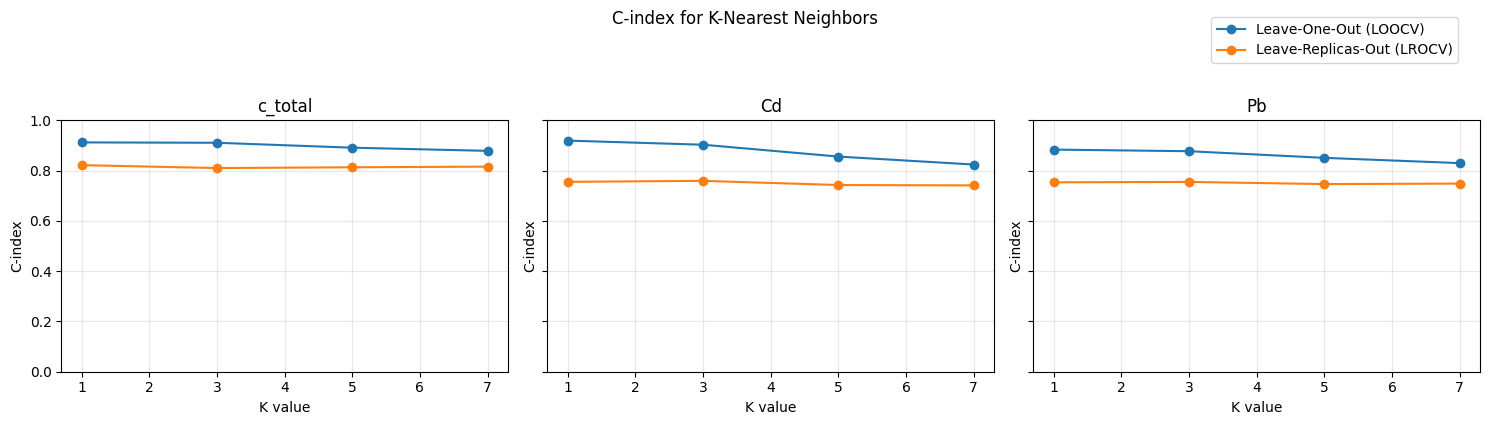

In [ ]:
targets = list(y.columns) # 3
k_list = list(knn_validator.k_values) # 1,3,5,7

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

for i, (ax, target) in enumerate(zip(axes, targets)):
    loocv = [knn_validator.loocv_results[k][target]["c_index"] for k in k_list]
    lrocv = [knn_validator.lrocv_results[k][target]["c_index"] for k in k_list]

    # if-else used for the legend to be at left most side and be one time only
    if i == 0:
        ax.plot(k_list, loocv, marker="o", label="Leave-One-Out (LOOCV)")
        ax.plot(k_list, lrocv, marker="o", label="Leave-Replicas-Out (LROCV)")
    else:
        ax.plot(k_list, loocv, marker="o")   # no label
        ax.plot(k_list, lrocv, marker="o")   # no label

    ax.set_title(target)
    ax.set_xlabel("K value")
    ax.set_ylabel("C-index")
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3)

fig.legend(loc="upper right", bbox_to_anchor=(0.98, 1.05), ncol=1, frameon=True)
fig.suptitle("C-index for K-Nearest Neighbors", y=1.05)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Interpretation of results:
#### Necessary questions for this case
1. Which cross-validation approach produced more optimistic results, and why?
2. Which cross-validation method provides a better estimate of the model's performance on unseen mixtures? Explain your answer.

#### Answers
1. <font color = coral> **LOOCV** produced the more optimistic results.
You can see it directly in the C-index: for every target (c_total, Cd, Pb) and across all k values, LOOCV consistently reports higher C-index scores than LROCV. For example, with c_total at k = 1, LOOCV achieves a C-index of 0.9122, while LROCV is 0.8218, a noticeable gap that reflects the more optimistic evaluation.
The main reason is the dataset structure: it contains replicas. When LOOCV leaves out a single point, the training set often still includes other replicas of the same mixture, so the model is learning from near-duplicates of what it’s tested on. That leakage inflates performance, making the model look like it generalizes well when it’s often just recognizing or interpolating within mixture types it has effectively already seen.</font>

2. <font color = steelblue> **LROCV** provides the better estimate of performance on unseen mixtures because it removes all replicas of a mixture from training when that mixture is used for testing. This prevents data leakage and evaluates the model on a truly new mixture type, matching real-world use. In contrast, **LOOCV** can be overly optimistic because replica samples often remain in the training set, making the test case too similar to what the model has already seen.</font>